In [1]:
START_DATE = "2000-01-01"
END_DATE = "2025-12-31"

In [2]:
from geopy.geocoders import Nominatim
import ee
from dotenv import load_dotenv
import os

ModuleNotFoundError: No module named 'geopy'

In [ ]:
load_dotenv()

True

In [ ]:
# Autentica com o Google Earth Engine
# Descomente se for a primeira execução
# ee.Authenticate()


In [ ]:
# Inicializa o Earth Engine
ee.Initialize(project=os.environ.get("GOOGLE_EARTH_ENGINE_PROJECT_ID"))

In [ ]:
# Geocodifica
geolocator = Nominatim(user_agent="geoapi")
location = geolocator.geocode("Manhuaçu, Minas Gerais, Brazil")
print("location:")
print(location)
print("\n")
point = ee.Geometry.Point([location.longitude, location.latitude])
print("point:")
print(point)

geometry = point.buffer(1000)  # 1 km de raio

# Usa essa geometria no filtro
ndvi_collection = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .filterBounds(geometry)
    .filterDate(START_DATE, END_DATE)
    .select("NDVI")
)

location:
Manhuaçu, Região Geográfica Imediata de Manhuaçu, Região Geográfica Intermediária de Juiz de Fora, Minas Gerais, Região Sudeste, Brasil


point:
ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Point",
    "arguments": {
      "coordinates": {
        "constantValue": [
          -42.0340769,
          -20.2574434
        ]
      }
    }
  }
})


In [ ]:
# Função para reduzir por média regional e transformar em Feature com data e valor
def image_to_feature(img):
    mean_dict = img.reduceRegion(
        reducer=ee.Reducer.mean(), geometry=geometry, scale=250, maxPixels=1e13
    )
    return ee.Feature(
        None, {"date": img.date().format("YYYY-MM-dd"), "ndvi": mean_dict.get("NDVI")}
    )

In [ ]:
# Aplica a função a todas as imagens
ndvi_features = ndvi_collection.map(image_to_feature)

In [ ]:
# Coleta os dados em Python
ndvi_list = ndvi_features.getInfo()['features']

In [ ]:
import pandas as pd  # Converte para DataFrame


data = [
    {"date": f["properties"]["date"], "ndvi": f["properties"]["ndvi"]}
    for f in ndvi_list
]
df = pd.DataFrame(data)

df["ndvi"] = pd.to_numeric(df["ndvi"], errors="coerce") / 10000  # escala 0–1

df

,date,ndvi
0,2000-02-18,0.482058
1,2000-03-05,0.476160
2,2000-03-21,0.483806
3,2000-04-06,0.495976
4,2000-04-22,0.468606
...,...,...
574,2025-02-02,0.403857
575,2025-02-18,0.366805
576,2025-03-06,0.407189
577,2025-03-22,0.383104


<Axes: xlabel='date'>

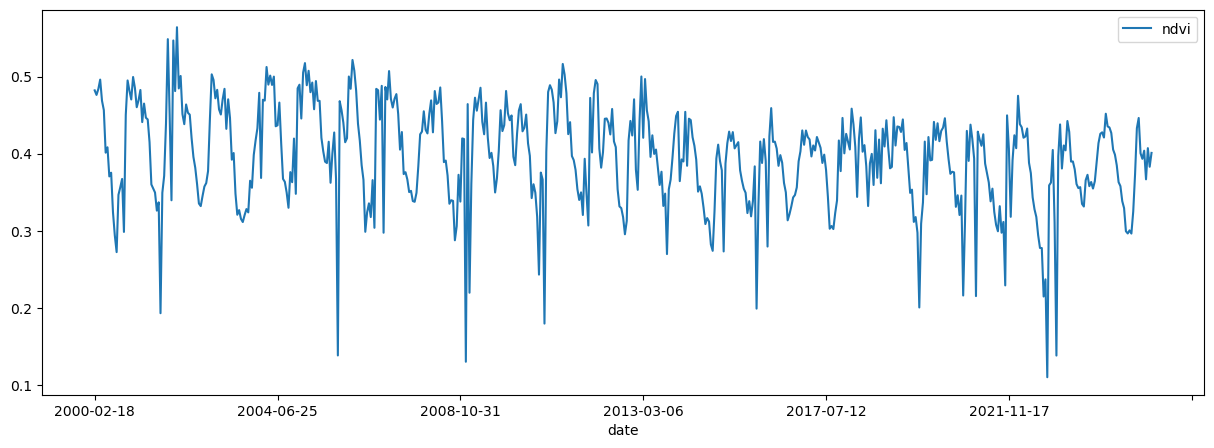

In [ ]:
df.plot(x="date", y="ndvi", figsize=(15, 5))

In [ ]:
# Exporta como CSV
if not os.path.exists("../data/GOOGLE_EARTH_ENGINE"):
    os.makedirs("../data/GOOGLE_EARTH_ENGINE")
df.to_csv("../data/GOOGLE_EARTH_ENGINE/ndvi_manhuacu.csv", index=False)
print("✅ CSV salvo com sucesso!")

✅ CSV salvo com sucesso!
